## A recommendation system with collaborative filtering

In [53]:
import json
import numpy as np
import pandas as pd
from scipy import optimize
from sklearn.metrics import mean_squared_error

In [2]:
# load the data
def json_to_df(path):
    data = []
    with open(path) as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame.from_dict(data)

In [3]:
review_df = json_to_df('yelp_dataset/yelp_academic_dataset_review.json')
business_df = json_to_df('yelp_dataset/yelp_academic_dataset_business.json')
#user_df = json_to_df('yelp_dataset/yelp_academic_dataset_user.json')

In [4]:
## Subset the business to only contain toronto restaurants (mainly because of memory issue)
business_df = business_df[business_df['categories'].str.contains('Restaurants') == True]
business_df = business_df[(business_df['city'] == 'Toronto') | (business_df['state'] == 'CA')]

In [5]:
business_df[business_df['state'] == 'CA']

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
26737,Via San Nullo 48,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",UntbR8C0Mxsfd-hNBZXO-w,"Pizza, Restaurants",Montreal,"{'Monday': '11:30-0:30', 'Tuesday': '11:30-0:3...",1,40.891417,14.092636,La Chamade,,80078,4,4.5,CA


Suprisingly, there is only one restaurant with state == 'CA' in our dataset, and this restaurant is in Canada instead of California. So we use restaurants in Montreal instead, just to test our model.

In [6]:
business_df = json_to_df('yelp_dataset/yelp_academic_dataset_business.json')

## Subset for restaurants in Tornto and Montreal
business_df = business_df[business_df['categories'].str.contains('Restaurants') == True]
business_df = business_df[(business_df['city'] == 'Toronto') | (business_df['city'] == 'Montreal')]

## Create dummy id for quick comparison
business_df.sort_values(by='business_id', inplace=True)
business_df['dummy_business_id'] = range(len(business_df))

trt_restaurants_df = business_df[(business_df['city'] == 'Toronto')]
mtl_restaurants_df = business_df[(business_df['city'] == 'Montreal')]

In [7]:
## Subset reviews to reviews on concerning restaurants only
review_df = review_df[review_df['business_id'].isin(list(business_df['business_id']))]

In [8]:
## Make dummy ids for review tables
review_df.sort_values(by='business_id', inplace=True)
id_list = list(review_df['business_id'])
dummy = [0] * len(review_df)
last = None
counter = -1
for i in range(len(dummy)):
    current = id_list[i]
    if current != last:
        counter += 1
    dummy[i] = counter
    last = current

review_df['dummy_business_id'] = dummy

In [9]:
dummy_id_list = business_df['dummy_business_id']

In [10]:
## Find user id for users who reviewed restaurants
user_id_list = list(review_df['user_id'].unique())

In [11]:
print("There are {} restaurants and {} users who reviewed them.".\
      format(len(dummy_id_list), len(user_id_list)))

There are 7729 restaurants and 83652 users who reviewed them.


In [12]:
review_df.sort_values(by='user_id', inplace=True)

In [13]:
## Make a dummy variable which index user_id
id_list = list(review_df['user_id'])
dummy = [0] * len(review_df)
last = None
counter = -1
for i in range(len(dummy)):
    current = id_list[i]
    if current != last:
        counter += 1
    dummy[i] = counter
    last = current

In [14]:
review_df['dummy_user_id'] = dummy

In [15]:
trt_review_df = review_df[review_df['dummy_business_id'].isin(list(trt_restaurants_df['dummy_business_id']))]
mtl_review_df = review_df[review_df['dummy_business_id'].isin(list(mtl_restaurants_df['dummy_business_id']))]

In [16]:
trt_user_id = set(trt_review_df['dummy_user_id'])
mtl_user_id = set(mtl_review_df['dummy_user_id'])

In [17]:
## Define travelers as users who reviewed both Toronto and Montreal restaurants
travelers = sorted(list(trt_user_id.intersection(mtl_user_id)))

In [19]:
review_df.sort_values(by='business_id', inplace=True)

In [21]:
## Create a m*k matrix which holds rating for restaurants(star)
## Each row represents a unique restaurant and each column represents a unique user.
## All ratings should be from 1-5, 0 represents missing value
m = len(business_df)
k = len(user_id_list)
rating_mtrx = np.zeros((m,k))
did_rate = np.zeros((m,k))

In [23]:
## radomly select half of travelers for prediction accuracy test
test_travelers = sorted(np.random.choice(travelers, len(travelers)//2, replace=False))

In [24]:
mtl_dummy_business_id = list(mtl_restaurants_df['dummy_business_id'])

In [44]:
## list to store masked indices
testset_indices = []
ground_truth = []

## store rated ratings into the matrix
ratings = list(review_df['stars'])
i_index = list(review_df['dummy_business_id'])
j_index = list(review_df['dummy_user_id'])
for c in range(len(ratings)):
    ## rating valid only if > 0
    if ratings[c] > 0:
        u_id = j_index[c]
        b_id = i_index[c]
        ## mask the rating if user is in test set
        if u_id in test_travelers and b_id in mtl_dummy_business_id:
            testset_indices.append((b_id, u_id))
            ground_truth.append(ratings[c])
        else:
            rating_mtrx[b_id, u_id] = ratings[c]
            did_rate[b_id, u_id] = 1

In [32]:
rating_mtrx.shape

(7729, 83652)

In [33]:
## Mean Normalize All The Ratings, only on entries that has ratings

def normalize_ratings(ratings, did_rate):
    num_restaurants = ratings.shape[0]
    ratings_mean = np.zeros(shape = (num_restaurants, 1))
    ratings_norm = np.zeros(shape = ratings.shape)

    for i in range(num_restaurants):
        # Get all the indexes where there is a 1
        idx = np.where(did_rate[i] ==1)[0]

        # Calculate mean rating of ith restaurant only from user's that gave a rating
        ratings_mean[i] = np.mean(ratings[i, idx])
        ratings_norm[i, idx] = ratings[i, idx] - ratings_mean[i]

    return (ratings_norm, ratings_mean)

In [34]:
ratings_norm, ratings_mean = normalize_ratings(rating_mtrx, did_rate)

In [35]:
## Define cost function
def calculate_cost(X_and_theta, ratings, did_rate, num_users, num_restaurants, num_features, reg_param):
    # Retrieve the X and theta matrixes from X_and_theta, based on their dimensions
    # ------------------------------------------------------------------------------------------------------
    # Get the first (m * 3) rows in the 3*(m+k) X 1 column vector
    first_3m = X_and_theta[:num_restaurants * num_features]
    # Reshape this column vector into a m X 3 matrix
    X = first_3m.reshape((num_features, num_restaurants)).transpose()
    # Get the rest of the numers, after the first 3*m
    last_3k = X_and_theta[num_restaurants * num_features:]
    # Reshape this column vector into a k X 3 matrix
    theta = last_3k.reshape(num_features, num_users).transpose()

    # we calculate the sum of squared errors here.  
    # in other words, we calculate the squared difference between our predictions and ratings
    cost = np.sum( (X.dot( theta.T ) * did_rate - ratings) ** 2 ) / 2
    print(cost)
    # we get the sum of the square of every element of X and theta
    regularization = (reg_param / 2) * (np.sum( theta**2 ) + np.sum(X**2))
    print('--')
    print(regularization)
    return cost + regularization

In [36]:
def calculate_gradient(X_and_theta, ratings, did_rate, num_users, num_restaurants, num_features, reg_param):
    # Retrieve the X and theta matrixes from X_and_theta, based on their dimensions 
    # --------------------------------------------------------------------------------------------------------
    # Get the first (m * 3) rows in the 3*(m+k) X 1 column vector
    first_3m = X_and_theta[:num_restaurants * num_features]
    # Reshape this column vector into a m X 3 matrix
    X = first_3m.reshape((num_features, num_restaurants)).transpose()
    # Get the rest of the numers, after the first 3*m
    last_3k = X_and_theta[num_restaurants * num_features:]
    # Reshape this column vector into a k X 3 matrix
    theta = last_3k.reshape(num_features, num_users).transpose()

    # we multiply by did_rate because we only want to consider observations for which a rating was given
    difference = X.dot(theta.T) * did_rate - ratings

    # we calculate the gradients (derivatives) of the cost with respect to X and theta
    X_grad = difference.dot( theta ) + reg_param * X
    theta_grad = difference.T.dot( X ) + reg_param * theta

    # wrap the gradients back into a column vector 
    return np.r_[X_grad.T.flatten(), theta_grad.T.flatten()]

In [76]:
num_restaurants, num_users = m, k
num_features = 3

# Initialize Parameters theta (user_prefs), X (restaurant_features)
restaurant_features = np.random.randn(num_restaurants, num_features)
user_prefs = np.random.randn(num_users, num_features)
initial_X_and_theta = np.r_[restaurant_features.T.flatten(), user_prefs.T.flatten()]

In [77]:

# Regularization paramater
reg_param = 30.0

# fprime simply refers to the derivative (gradient) of the calculate_cost function
# We iterate 100 times
minimized_cost_and_optimal_params = optimize.fmin_cg(calculate_cost, fprime=calculate_gradient, x0=initial_X_and_theta, \
                            args=(ratings_norm, did_rate, num_users, num_restaurants, num_features, reg_param), \
                            maxiter=100, disp=True, full_output=True )

714899.6557892452
--
4094599.955567298
703473.7287224196
--
4081841.2138931463
660556.5653145867
--
4031112.277196538
529914.9847733818
--
3833093.010410108
469558.6496145446
--
3119359.6232643872
313234.9979143562
--
1994639.1560455856
1239352.7714089302
--
870283.1174738271
896334.2254346274
--
758486.0651214179
2419395.4506905745
--
583966.2075257424
431804.9253772725
--
640151.8582546451
420336.94339028245
--
621480.0377184711
2386407.0964831454
--
509567.47632284375
309375.0595227594
--
584255.134924865
437925.3341230914
--
544276.5825556145
271364.1524995464
--
568517.270973414
237062.6434679031
--
538941.5564877738
552922.5510242068
--
484557.3525975663
236003.33307013154
--
530292.0452940608
234669.13441983322
--
512798.8909142519
239240.11804936867
--
446387.2275152273
301529.1649666326
--
237715.83984251186
2915760.6195133356
--
314634.5439257675
286757.3418561209
--
118475.85039690704
424490.01283124747
--
84622.89976821328
251705.1397784863
--
91942.64222510446
268551.05380

In [78]:
# Retrieve the minimized cost and the optimal values of the movie_features (X) and user_prefs (theta) matrices
cost, optimal_restaurant_features_and_user_prefs = \
minimized_cost_and_optimal_params[1], minimized_cost_and_optimal_params[0]

In [79]:
first_3m = optimal_restaurant_features_and_user_prefs[:num_restaurants * num_features]
restaurant_features = first_3m.reshape((num_features, num_restaurants)).transpose()
last_3k = optimal_restaurant_features_and_user_prefs[num_restaurants * num_features:]
user_prefs = last_3k.reshape(num_features, num_users ).transpose()

In [80]:
## Making predictions
all_predictions = restaurant_features.dot(user_prefs.T) + ratings_mean

In [82]:
mtl_predictions = [all_predictions[testset_indices[i][0], testset_indices[i][1]] \
                   for i in range(len(testset_indices))]

In [83]:
mean_squared_error(mtl_predictions, ground_truth)

0.9962436865405387

In [58]:
import matplotlib.pyplot as plt

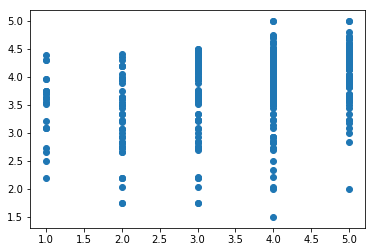

In [84]:
plt.scatter(ground_truth, mtl_predictions)

In [100]:
## compare with predicting the ratings by mean
mean_predictions = [ratings_mean[t[0]][0] for t in testset_indices]

In [102]:
mean_squared_error(mean_predictions, ground_truth)

0.9965134661794739